IMPORT NECESSARY LIBARIES

In [2]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


Data Loading 

In [3]:
# load the dataset
path = r"C:\Workspaces\Project\DA Elite\June\Data\HR_comma_sep.csv"
hr_df = pd.read_csv(path)

hr_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Data Cleaning

In [4]:
# Rename average_montly_hour to average_monthly_hour
hr_df.rename(columns= {'average_montly_hours': 'average_monthly_hours'}, inplace= True)

In [5]:
# Check Missing Value
print("Missing values:")
print(hr_df.isnull().sum())

Missing values:
satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64


 Feature Engineering

In [6]:
# Create workload index: Project count * Monthly hours
hr_df['workload_index'] = hr_df['number_project'] * hr_df['average_monthly_hours']

# Create a binary feature to get a long_term employee
hr_df['long_term_employee'] = (hr_df['time_spend_company'] >= 4).astype(int)


Explanatory Data Analysis

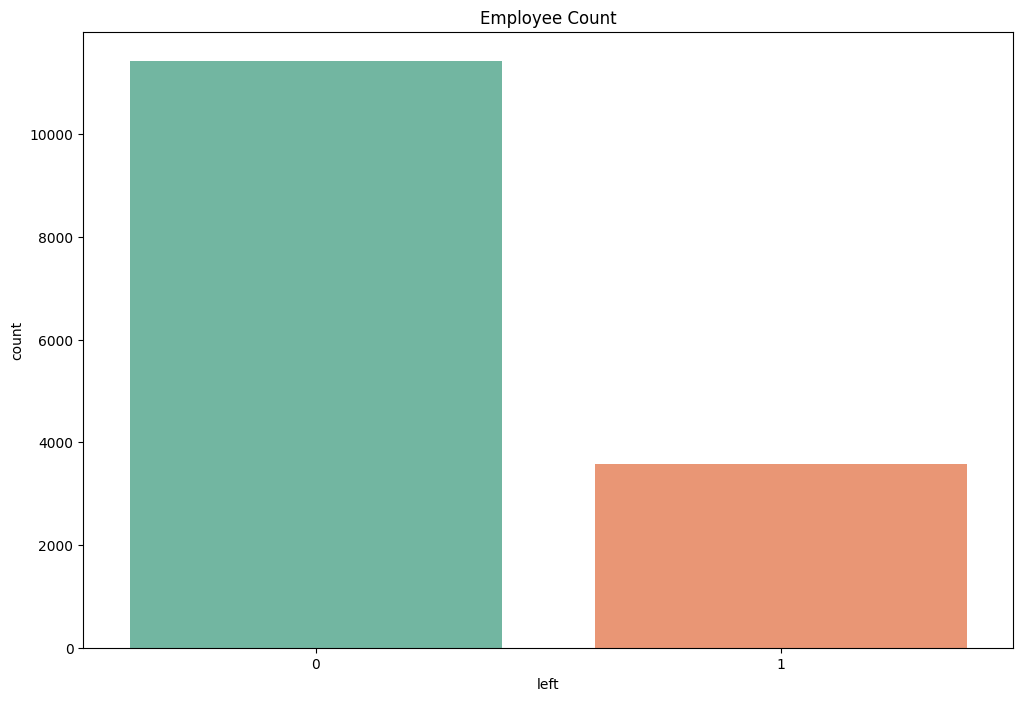

In [7]:
# Attrition Count
plt.figure(figsize=(12, 8))
sns.countplot(data=hr_df, x='left', palette= 'Set2')
plt.title('Employee Count')
plt.show()

Correlation Heatmap

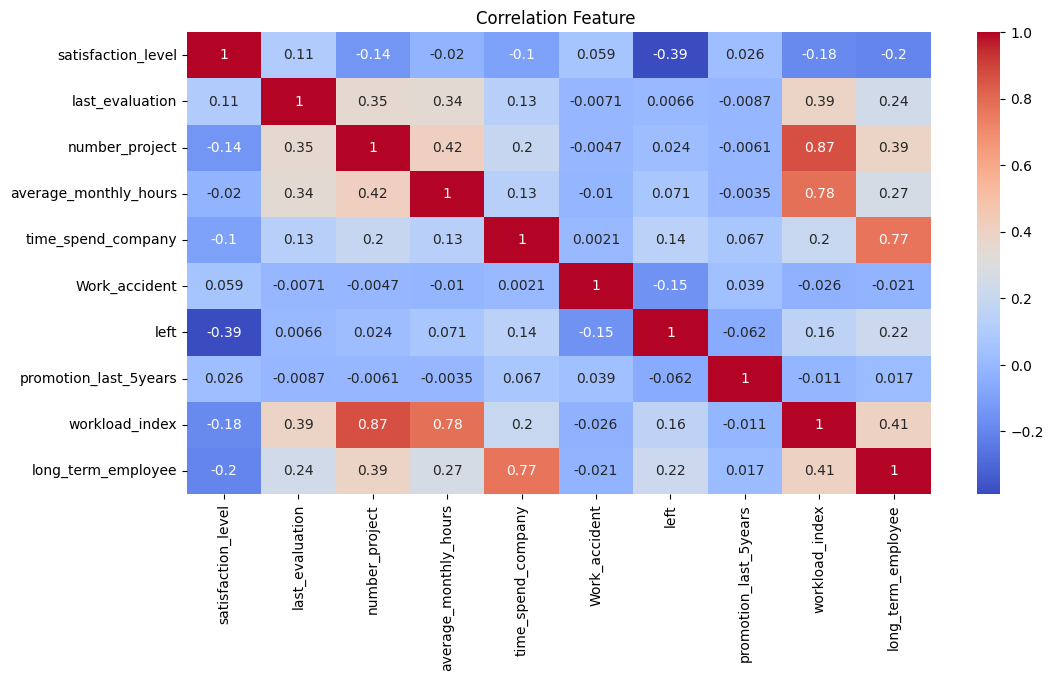

In [8]:
plt.figure(figsize=(12,6))
sns.heatmap(hr_df.corr(numeric_only= True), annot= True, cmap= 'coolwarm')
plt.title('Correlation Feature ')
plt.show()

Satisfaction level vs Attrition

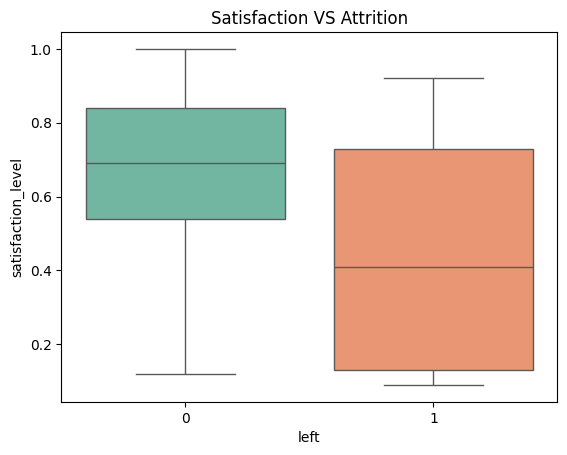

In [9]:
sns.boxplot(data= hr_df, x= 'left', y= 'satisfaction_level', palette= 'Set2')
plt.title("Satisfaction VS Attrition")
plt.show()

Department VS Attrition

In [10]:
# Create a dataframe to group attrition by department
left_dept = hr_df[hr_df['left'] == 1]
dept_by_attrition = left_dept.groupby('Department')['left'].sum().sort_values(ascending= True)


In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=dept_by_attrition.index, y=dept_by_attrition.values, color='skyblue')
plt.title('Attrition by Department')
plt.xlabel('Department')
plt.ylabel('Number of Employees Left')
plt.show()

Salary vs Attrition

In [ ]:
# create a dataframe to group attrition by salary
salary_left = left_dept.groupby('salary')['left'].sum().sort_values(ascending= True)
plt.figure(figsize=(12, 6))
sns.barplot(x= salary_left.index, y= salary_left.values, color='skyblue')
plt.title('Attrition by Salary')
plt.xlabel('Salary')
plt.ylabel('Number of Employees Left')
plt.show()

Data Preprocessing

In [ ]:
# 6. Data Preprocessing Pipeline
features = hr_df.drop('left', axis=1)
target = hr_df['left']

# Define feature types
numeric_features = ['satisfaction_level', 'last_evaluation', 'number_project',
                    'average_monthly_hours', 'time_spend_company',
                    'workload_index']
categorical_features = ['Department', 'salary']
binary_features = ['Work_accident', 'promotion_last_5years', 'long_term_employee']


Preprocessing Pipeline

In [ ]:

# Preprocessing transformers
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')  # keep binary features

Model Pipeline

In [ ]:
# Define model pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

Split data and train Model on test set


In [ ]:
# split data into features and target and train the modelon test set
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

Predict and Evaluate

In [ ]:

# Predict and Evaluate
y_pred = model_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred)) # Evaluate model performance using accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred)) # Export classification report(Precison, Recall, F1-score)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) #

Feature Importance

In [ ]:

# 7. Check for Feature Importance with the logistic regression classifier
model = model_pipeline.named_steps['classifier']
importances = model.feature_importances_
feature_names = (
    numeric_features +
    list(model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)) +
    binary_features
)

feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False) # export feature importance to pandas series


Accuracy: 0.9906666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.96      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Confusion Matrix:
 [[2283    3]
 [  25  689]]


Plot feature Inportance

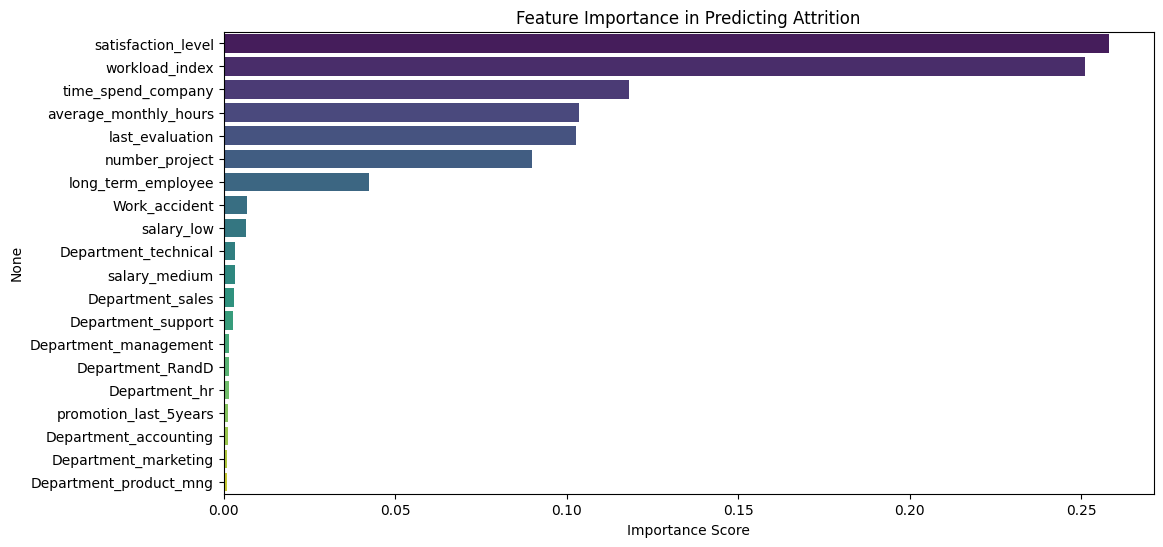

In [14]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance in Predicting Attrition')
plt.xlabel('Importance Score')
plt.show()


In [15]:
print(feature_importance)

satisfaction_level        0.258228
workload_index            0.251186
time_spend_company        0.118248
average_monthly_hours     0.103568
last_evaluation           0.102633
number_project            0.089811
long_term_employee        0.042329
Work_accident             0.006789
salary_low                0.006450
Department_technical      0.003342
salary_medium             0.003208
Department_sales          0.002938
Department_support        0.002626
Department_management     0.001471
Department_RandD          0.001446
Department_hr             0.001427
promotion_last_5years     0.001301
Department_accounting     0.001233
Department_marketing      0.000933
Department_product_mng    0.000833
dtype: float64


save the model

In [16]:
import joblib

# Save the entire pipeline
joblib.dump(model_pipeline, 'model_pipeline.pkl')


['model_pipeline.pkl']